In [1]:
import numpy as np
import torch as th

from Env.env import BSMarket

In [2]:
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [ ]:
from Algorithms.ddpg import config

env_kwargs, model_kwargs, learn_kwargs = config.load_config('../Algorithms/learn/ddpg/tmp_config.yaml')

In [ ]:
from pprint import pprint

pprint(env_kwargs)

In [5]:
env1 = BSMarket(**env_kwargs)
env2 = BSMarket(**env_kwargs)

env 'BSMarket was created!
env 'BSMarket was created!


## Comparison btw P&L reward and Cashflow reward

In [25]:
def log_rewards(env, reward_mode, model=None):
    env.seed(42)
    env.action_space.seed(42)

    obs = env.reset()
    tmp = env.reward_mode
    env.reward_mode = reward_mode
    done, info = False, None
    reward_logs = []
    reward2_logs = []
    while not done:
        if model is not None:
            action, _ = model.predict(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        reward_logs.append(reward)
        reward2_logs.append(info['mean_square_reward'])

    env.reward_mode = tmp
    return np.array(reward_logs), np.array(reward2_logs)

In [26]:
rlog_pnl, r2log_pnl = log_rewards(env1, 'pnl')
rlog_cash, r2log_cash = log_rewards(env2, 'cash')

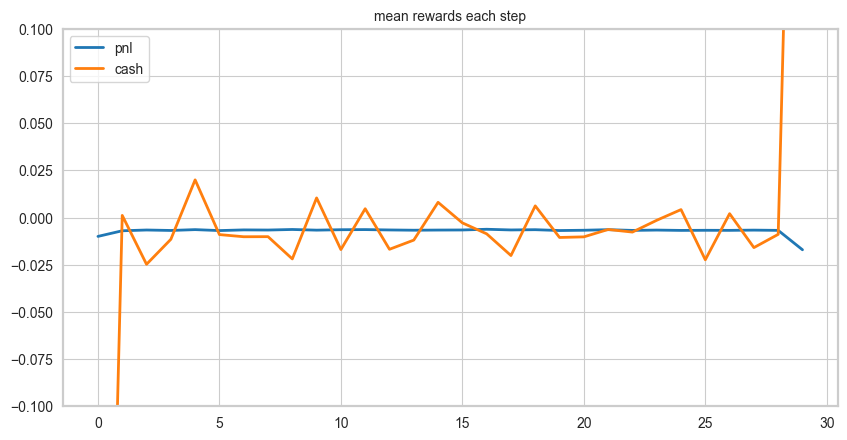

In [31]:
plt.title('mean rewards each step')
plt.plot(rlog_pnl, label='pnl')
plt.plot(rlog_cash, label='cash')
plt.ylim(-0.1, 0.1)
plt.legend()
plt.show()

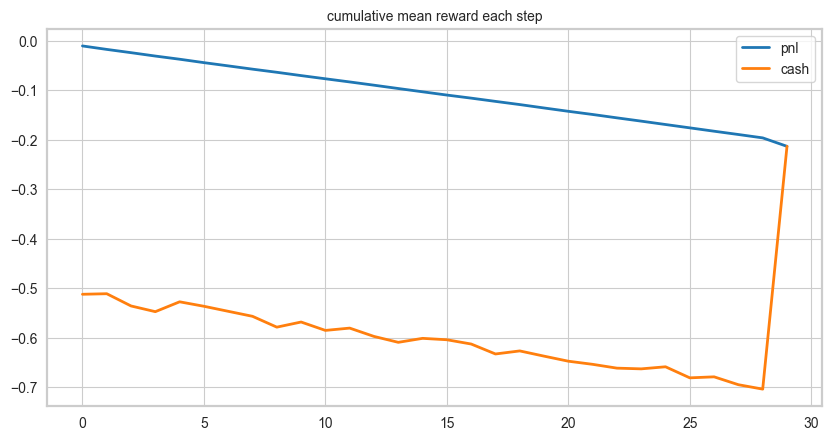

In [30]:
plt.title('cumulative mean reward each step')
plt.plot(np.cumsum(rlog_pnl), label='pnl')
plt.plot(np.cumsum(rlog_cash), label='cash')
plt.legend()
plt.show()

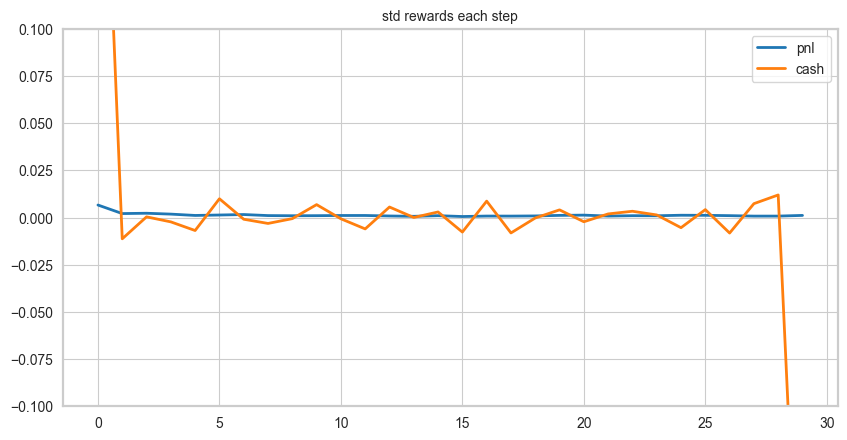

In [8]:
plt.title('std rewards each step')
plt.plot(r2log_pnl, label='pnl')
plt.plot(r2log_cash, label='cash')
plt.ylim(-0.1, 0.1)
plt.legend()
plt.show()

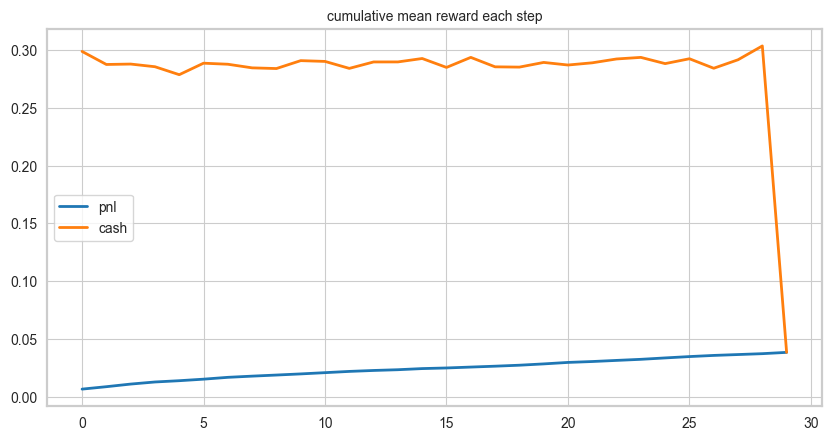

In [9]:
plt.title('cumulative mean reward each step')
plt.plot(np.cumsum(r2log_pnl), label='pnl')
plt.plot(np.cumsum(r2log_cash), label='cash')
plt.legend()
plt.show()

In [37]:
def log_raw_rewards(env, reward_mode, model=None):
    env.seed(42)
    env.action_space.seed(42)

    obs = env.reset()
    tmp = env.reward_mode
    env.reward_mode = reward_mode
    done, info = False, None
    reward_logs = []
    now_reward = 0
    while not done:
        if model is not None:
            action, _ = model.predict(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        reward_logs.append(env.raw_reward - now_reward)
        now_reward = env.raw_reward.copy()

    env.reward_mode = tmp
    return np.array(reward_logs)

In [38]:
rlog_pnl = log_raw_rewards(env1, 'pnl')
rlog_cash = log_raw_rewards(env2, 'cash')

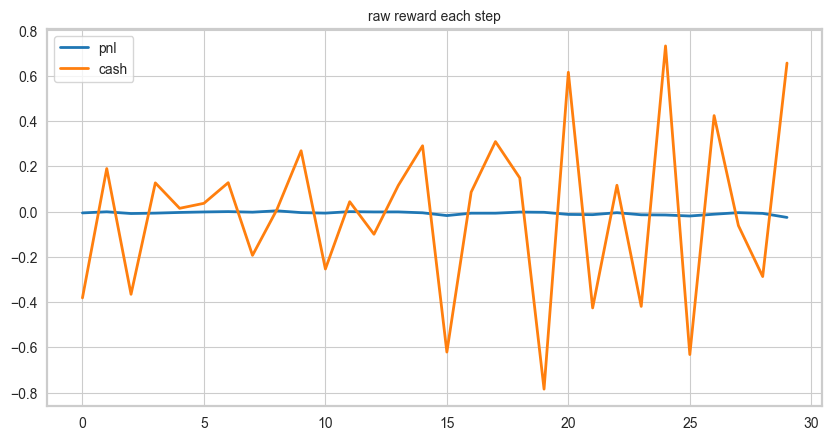

In [39]:
plt.title('raw reward each step')
plt.plot(rlog_pnl[:, 0], label='pnl')
plt.plot(rlog_cash[:, 0], label='cash')
plt.legend()
plt.show()

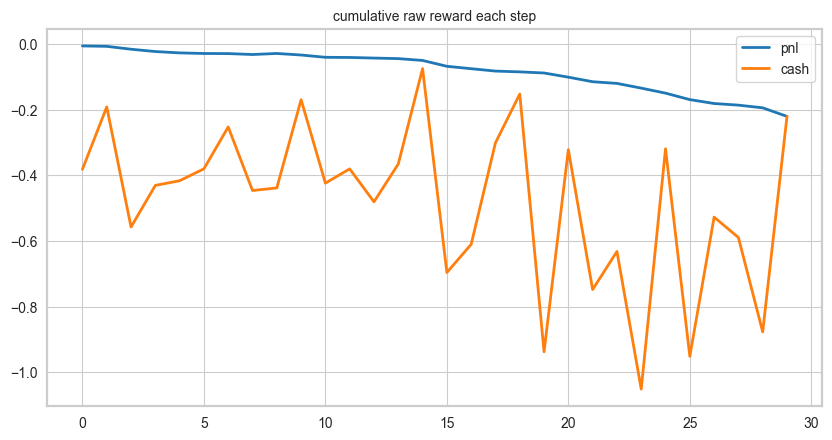

In [40]:
plt.title('cumulative raw reward each step')
plt.plot(rlog_pnl[:, 0].cumsum(), label='pnl')
plt.plot(rlog_cash[:, 0].cumsum(), label='cash')
plt.legend()
plt.show()

# Delta Hedging vs Random

In [21]:
from Utils.prices import european_call_delta

def delta_hedging(env):
    env.seed(42)
    obs = env.reset()
    done, info = False, {}
    reward_logs = []
    reward2_logs = []
    while not done:
        moneyness, expiry, volatility, drift = [obs['obs'][..., i] for i in range(4)]
        action = european_call_delta(moneyness, expiry, volatility, drift)
        obs, reward, done, info = env.step(action)
        reward_logs.append(reward)
        reward2_logs.append(info['mean_square_reward'])

    return np.array(reward_logs), np.array(reward2_logs)

In [27]:
delta_r, delta_r2 = delta_hedging(env1)
random_r, random_r2 = log_rewards(env1, 'pnl')

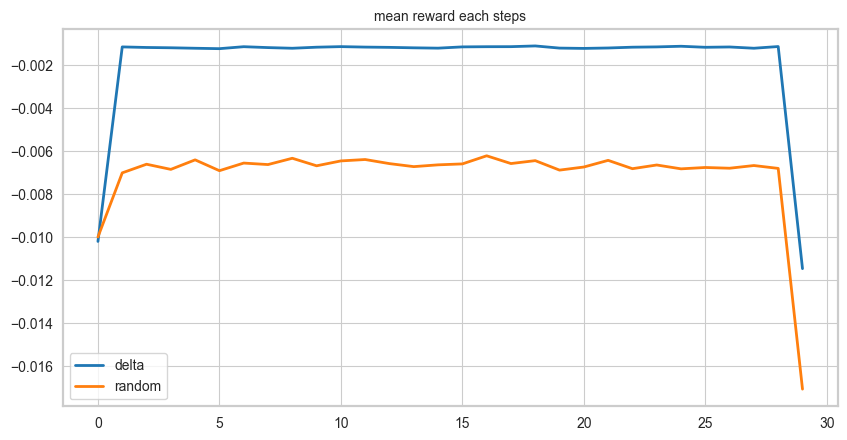

In [28]:
plt.title("mean reward each steps")
plt.plot(delta_r, label='delta')
plt.plot(random_r, label='random')
plt.legend()
plt.show()

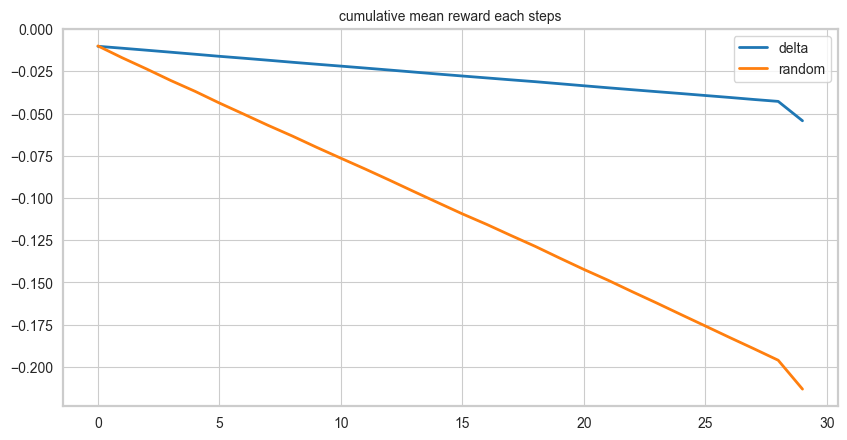

In [29]:
plt.title("cumulative mean reward each steps")
plt.plot(delta_r.cumsum(), label='delta')
plt.plot(random_r.cumsum(), label='random')
plt.legend()
plt.show()

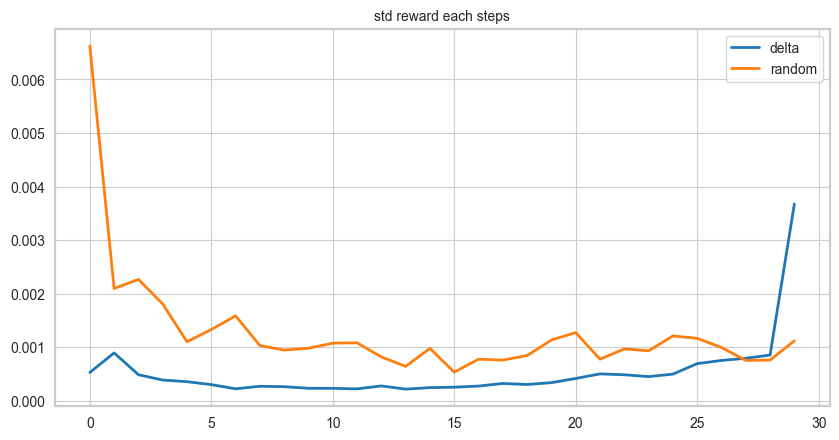

In [19]:
plt.title("std reward each steps")
plt.plot(delta_r2, label='delta')
plt.plot(random_r2, label='random')
plt.legend()
plt.show()